The working directory for coloab is the "Content" folder. We can see the available folder structure from clicking on the folder icon on the left.

There we can upload files from our local system.


In [0]:
import os
import zipfile

local_zip = 'real_and_fake_face_ReduceD.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('real_and_fake_face') #extracting the zip file and putting it in folder named 'real_and_fake_face' 
zip_ref.close()


Let's see few file names from both the directories

In [12]:
# Directory with our training Real Face pictures
train_Real_dir = os.path.join('real_and_fake_face/real_and_fake_face_ReduceD/Real Face')

# Directory with our training Fake Face pictures
train_Fake_dir = os.path.join('real_and_fake_face/real_and_fake_face_ReduceD/Fake Face')

train_Real_names = os.listdir(train_Real_dir)
print(train_Real_names[:5])

train_Fake_names = os.listdir(train_Fake_dir)
print(train_Fake_names[:5])

['real_00020.jpg', 'real_00029.jpg', 'real_00012.jpg', 'real_00027.jpg', 'real_00030.jpg']
['easy_9_1010.jpg', 'easy_16_1111.jpg', 'easy_4_0011.jpg', 'easy_24_0011.jpg', 'easy_25_0110.jpg']


We can get the total number of images in the respective directories

In [13]:
print('Total training real images:', len(os.listdir(train_Real_dir)))
print('total training fake images:', len(os.listdir(train_Fake_dir)))

Total training real images: 33
total training fake images: 33


Now let's see some of the pictures. But first,need configure the necessary libraries and parameters:

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 3x3 configuration
nrows = 3
ncols = 3

# Index for iterating over images
pic_index = 0

Now, display a batch of 4 Real and 4 Fake pictures. You can rerun the cell to see a fresh batch each time:

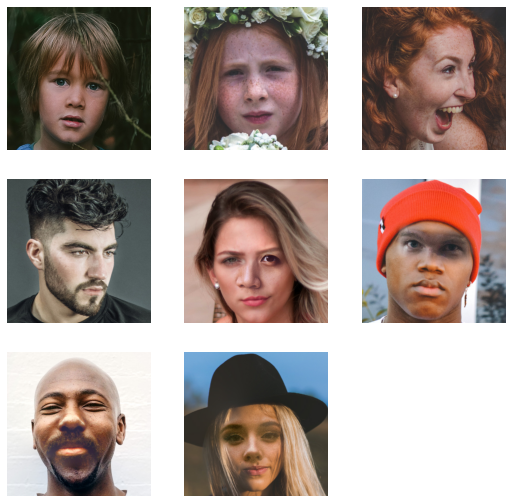

In [16]:
# Set up matplotlib fig, and size it to fit 3x3 pics
fig = plt.gcf() 
fig.set_size_inches(ncols * 3, nrows * 3)

pic_index += 4
next_Real_pix = [os.path.join(train_Real_dir, fname) 
                for fname in train_Real_names[pic_index-4:pic_index]]
next_Fake_pix = [os.path.join(train_Fake_dir, fname) 
                for fname in train_Fake_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_Real_pix+next_Fake_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()



<h2>Lets Build the model now</h2>



Let's start by importing TensorFlow library

In [0]:
import tensorflow as tf

Now we will be building the densely connected Convolutional Neural Network

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # # The fourth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # # The fifth convolution
    # tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('Real') and 1 for the other ('Fake')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'real_and_fake_face/real_and_fake_face_ReduceD/',  # This is the source directory for training images
        target_size=(300, 300),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 66 images belonging to 2 classes.


In [0]:
DESIRED_ACCURACY = 0.999

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy')>DESIRED_ACCURACY):
            self.model.stop_training=True
            print('Reached 99.9% accuracy so cancelling training!')

callbacks = myCallback()

In [29]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=10,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/10
8/8 [==============================] - 40s 5s/step - loss: 0.6056 - accuracy: 0.7576
Epoch 2/10
8/8 [==============================] - 41s 5s/step - loss: 0.4319 - accuracy: 0.8447
Epoch 3/10
8/8 [==============================] - 41s 5s/step - loss: 0.4252 - accuracy: 0.8390
Epoch 4/10
8/8 [==============================] - 40s 5s/step - loss: 0.2449 - accuracy: 0.9091
Epoch 5/10
8/8 [==============================] - 40s 5s/step - loss: 0.0605 - accuracy: 1.0000


<h3>Now Let's see how the model works on Unseen photos</h3>

In [40]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a fake")
  else:
    print(fn + " is a real")

Saving 83ab0464037aeae48b29322f9a50a692.jpg to 83ab0464037aeae48b29322f9a50a692.jpg
[0.05938262]
83ab0464037aeae48b29322f9a50a692.jpg is a real
